In [1]:
%cd /home/hyoju/바탕화면/RealForensics/data/Forensics

/home/hyoju/바탕화면/RealForensics/data/Forensics


In [2]:
import pandas as pd
import os
import cv2
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Resize, ToTensor
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def load_dataset(file_path, root_dir, label_dirs, frames_limit):
    df = pd.read_csv(file_path, delim_whitespace=True, names=['filename', 'label'])
    dataset = []
    for idx, row in df.iterrows():
        video_name = row['filename']
        label = row['label']
        file_loaded = False  # 파일 로딩 성공 여부를 추적하는 플래그
        for label_dir in label_dirs:
            full_path = os.path.join(root_dir, label_dir, 'c23', 'cropped_faces', video_name)
            if os.path.exists(full_path):
                dataset.append((full_path, int(label), frames_limit))
                file_loaded = True
                break
        if not file_loaded:
            print(f"Warning: {video_name} not found in any specified directories.")
    print(f"Loaded {len(dataset)} items from {file_path}")
    return dataset

# 'root_dir'를 현재 작업 디렉토리(.)로 설정
root_dir = '.'
csv_dir = os.path.join(root_dir, 'csv_files')
label_dirs = ['Deepfakes', 'Face2Face', 'FaceShifter', 'FaceSwap', 'NeuralTextures', 'Real']

frames_limit=90

train_label_dirs = ['Deepfakes', 'Face2Face', 'FaceSwap', 'NeuralTextures', 'Real']  # FaceShifter 제외
train_dataset = sum([load_dataset(os.path.join(csv_dir, f'train_{label}.csv'), root_dir, train_label_dirs, frames_limit=frames_limit) for label in ['fake', 'real']], [])

val_label_dirs = ['FaceShifter', 'Real']  # FaceShifter와 Real만 포함
val_dataset = load_dataset(os.path.join(csv_dir, 'val_fake.csv'), root_dir, val_label_dirs, frames_limit=frames_limit) + \
               load_dataset(os.path.join(csv_dir, 'val_real.csv'), root_dir, val_label_dirs, frames_limit=frames_limit)

test_label_dirs = ['FaceShifter', 'Real']  # FaceShifter와 Real만 포함
test_dataset = load_dataset(os.path.join(csv_dir, 'test_fake.csv'), root_dir, test_label_dirs, frames_limit=frames_limit) + \
               load_dataset(os.path.join(csv_dir, 'test_real.csv'), root_dir, test_label_dirs, frames_limit=frames_limit)

Loaded 720 items from ./csv_files/train_fake.csv
Loaded 720 items from ./csv_files/train_real.csv
Loaded 140 items from ./csv_files/val_fake.csv
Loaded 140 items from ./csv_files/val_real.csv
Loaded 140 items from ./csv_files/test_fake.csv
Loaded 140 items from ./csv_files/test_real.csv


In [4]:
from torchvision.transforms import RandomCrop, Resize, RandomHorizontalFlip, RandomGrayscale, ToTensor, Compose
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
import cv2
import numpy as np
import os
import pandas as pd
from PIL import Image

class VideoDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        video_path, label, frames_limit = self.dataset[idx]
        cap = cv2.VideoCapture(video_path)
        frames = []
        frame_count = 0
        while True:
            ret, frame = cap.read()
            if not ret or frame_count == frames_limit:
                break
            if self.transform:
                # frame을 PIL Image로 변환 후 transform
                frame = Image.fromarray(frame)
                frame = self.transform(frame)
            frames.append(np.array(frame))  # transform 후 다시 numpy 배열로 변환
            frame_count += 1
        cap.release()

        # 프레임 수가 frames_limit보다 적은 경우, 마지막 프레임을 반복하여 추가
        while len(frames) < frames_limit:
            frames.append(frames[-1])

        # 첫 frames_limit 개수의 프레임만 사용
        frames = frames[:frames_limit]
        frames = np.stack(frames)
        #print(f"Before transpose frames shape: {frames.shape}")  # (60, 3, 112, 112)
        frames = np.transpose(frames, (1, 0, 2, 3))  # 채널 차원을 맞추기 위한 조정 (C, D, H, W)
        #print(f"Final frames shape: {frames.shape}")  # (60, 3, 112, 112)
        return frames, label

# 새로운 변환 정의
transform = Compose([
    RandomCrop(140),
    Resize((112, 112)),
    #Resize((28, 28)),
    RandomHorizontalFlip(p=0.5),
    RandomGrayscale(p=0.5),
    ToTensor(),
])

def make_sampler(dataset, num_samples=144, fake_weight=16, real_weight=128):
    targets = [label for _, label, _ in dataset] # dataset은 (video_path, label, frames_limit) 튜플의 리스트
    weights = [fake_weight if label == 1 else real_weight for label in targets]
    sampler = WeightedRandomSampler(weights, num_samples=num_samples, replacement=True)
    return sampler

batch_size = 32


train_sampler = make_sampler(train_dataset)
val_sampler = make_sampler(val_dataset, num_samples=len(val_dataset))
test_sampler = make_sampler(test_dataset, num_samples=len(test_dataset))

train_loader = DataLoader(VideoDataset(train_dataset, transform=transform), batch_size=batch_size, sampler=train_sampler)
val_loader = DataLoader(VideoDataset(val_dataset, transform=transform), batch_size=len(val_dataset), sampler=val_sampler)
test_loader = DataLoader(VideoDataset(test_dataset, transform=transform), batch_size=len(test_dataset), sampler=test_sampler)

In [4]:
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

# 모델 정의
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.fc1 = nn.Linear(16*15*28*28, 512)
        self.fc2 = nn.Linear(512, 2)

    def forward(self, x):
        #print(f"Initial input shape: {x.shape}") # 4, 3, 60, 112, 112
        x = self.pool(F.relu(self.conv1(x)))
        #print(f"After conv1 shape: {x.shape}") # 4, 8, 30, 56, 56
        x = self.pool(F.relu(self.conv2(x)))
        #print(f"After conv2 shape: {x.shape}") # 4, 16, 15, 28, 28
        x = x.view(x.size(0), -1)  # x.size(0)은 배치 크기, Flatten the tensor
        #print(f"Before FC layers shape: {x.shape}") # 4, 16*15*28*28
        x = F.relu(self.fc1(x))
        #print(f"After fc1 shape: {x.shape}")
        x = self.fc2(x)
        #print(f"Output shape: {x.shape}")
        return x
'''


'\nimport torch\nimport torch.nn as nn\nimport torch.nn.functional as F\n\n# 모델 정의\nclass Simple3DCNN(nn.Module):\n    def __init__(self):\n        super(Simple3DCNN, self).__init__()\n        self.conv1 = nn.Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))\n        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))\n        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))\n        self.fc1 = nn.Linear(16*15*28*28, 512)\n        self.fc2 = nn.Linear(512, 2)\n\n    def forward(self, x):\n        #print(f"Initial input shape: {x.shape}") # 4, 3, 60, 112, 112\n        x = self.pool(F.relu(self.conv1(x)))\n        #print(f"After conv1 shape: {x.shape}") # 4, 8, 30, 56, 56\n        x = self.pool(F.relu(self.conv2(x)))\n        #print(f"After conv2 shape: {x.shape}") # 4, 16, 15, 28, 28\n        x = x.view(x.size(0), -1)  # x.size(0)은 배치 크기, Flatten the tensor\n        #print(f"Before FC layers shape: {x.shape}")

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ConvLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters:
            input_dim (int) - Number of channels of input tensor.
            hidden_dim (int) - Number of channels of hidden state.
            kernel_size (int or (int, int)) - Size of the convolutional kernel.
            bias (bool) - Whether or not to add the bias.
        """
        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = (kernel_size[0] // 2, kernel_size[1] // 2)
        self.bias = bias

        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,  # for input_gate, forget_gate, current_state, output_gate
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


class SimpleConvLSTMModel(nn.Module):
    def __init__(self):
        super(SimpleConvLSTMModel, self).__init__()

        # ConvLSTM 셀
        self.convLSTM1 = ConvLSTMCell(input_dim=3, hidden_dim=32, kernel_size=(3, 3), bias=True)
        self.convLSTM2 = ConvLSTMCell(input_dim=32, hidden_dim=64, kernel_size=(3, 3), bias=True)

        # average pooling으로 시간적 차원 축소
        self.avgPool = nn.AdaptiveAvgPool3d((1, None, None))

        # fully connected layer
        self.fc1 = nn.Linear(3*60*112*112, 512)
        self.fc2 = nn.Linear(512, 2)


    def forward(self, x):
        # x: (batch_size, channels, depth, height, width)
        batch_size, _, depth, height, width = x.size()
        #print(f"Initial input shape: {x.shape}")

        # 초기 상태
        h1, c1 = self.convLSTM1.init_hidden(batch_size, (height, width))
        #print(f"After conv1 shape: {x.shape}")
        h2, c2 = self.convLSTM2.init_hidden(batch_size, (height, width))
        #print(f"After conv2 shape: {x.shape}")

        # 모든 시간 스텝을 순회
        for t in range(depth):
            # 현재 시간 스텝의 프레임을 가져옴
            current_frame = x[:, :, t, :, :]
            # ConvLSTM 셀을 통과
            h1, c1 = self.convLSTM1(current_frame, (h1, c1))
            h2, c2 = self.convLSTM2(h1, (h2, c2))

        # 시간 차원에 대해 평균 풀링
        pooled = self.avgPool(h2.unsqueeze(2))  # (batch_size, channels, 1, height, width)
        #print(f"After pooling shape: {x.shape}")

        # 텐서 평탄화 전의 출력 크기를 동적으로 계산
        flat_size = x.size(1) * x.size(2) * x.size(3)
        x = x.view(x.size(0), -1)  # 배치 크기를 유지하면서 평탄화
        #print(f"After flattening shape: {x.shape}")
        # 동적으로 계산된 크기를 사용하여 fc 레이어 적용
        x = self.fc1(x)
        #print(f"After FC1 layers shape: {x.shape}")
        x = self.fc2(x)
        return x


### conv + lstm layer
- default: conv4 lstm1

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CNN
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv4 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.lstm = nn.LSTM(input_size=64*7*7, hidden_size=128, num_layers=1, batch_first=True)

        #self.fc1 = nn.Linear(64*3*3*3, 512)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):

        #print(f"Initial input shape: {x.shape}") # 4, 3, 60, 56, 56

        x = self.pool(F.relu(self.conv1(x)))
        #print(f"After conv1 shape: {x.shape}") # 4, 8, 30, 28, 28

        x = self.pool(F.relu(self.conv2(x)))
        #print(f"After conv2 shape: {x.shape}") # 4, 16, 15, 14, 14

        x = self.pool(F.relu(self.conv3(x)))
        #print(f"After conv3 shape: {x.shape}") # 4, 32, 7, 7, 7

        x = self.pool(F.relu(self.conv4(x)))
        #print(f"After conv4 shape: {x.shape}") # 4, 64, 3, 3, 3

        # LSTM을 위한 준비: (batch_size, seq_len, features)
        x = x.view(x.size(0), x.size(2), -1)  # x.size(0)은 배치 크기, Flatten the tensor
        #print(f"Before LSTM layers shape: {x.shape}") # 4, 32*3*7*7

        # LSTM을 통과
        lstm_out, (h_n, c_n) = self.lstm(x)
        #print(f"After LSTM layers shape: {x.shape}")
        x = lstm_out[:, -1, :]  # 시퀀스의 마지막 출력만 사용
        #print(f"시퀀스의 마지막 출력만 사용 이후 shape: {x.shape}")
        #x = F.relu(self.fc1(x))
        #print(f"After fc1 shape: {x.shape}")
        x = self.fc(x)
        #print(f"Output shape: {x.shape}")
        return x


- conv3, lstm1

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CNN
class Simple3DCNN(nn.Module):
    def __init__(self):
        super(Simple3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 16, kernel_size=(3, 7, 7), stride=(1, 1, 1), padding=(1, 3, 3))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv2 = nn.Conv3d(16, 32, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(1, 2, 2))
        self.pool = nn.MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2))
        self.conv3 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        #self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        #self.conv4 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.lstm = nn.LSTM(input_size=64*14*14, hidden_size=128, num_layers=1, batch_first=True)

        #self.fc1 = nn.Linear(64*3*3*3, 512)
        self.fc = nn.Linear(128, 2)

    def forward(self, x):

        print(f"Initial input shape: {x.shape}") # 4, 3, 60, 56, 56

        x = self.pool(F.relu(self.conv1(x)))
        print(f"After conv1 shape: {x.shape}") # 4, 8, 30, 28, 28

        x = self.pool(F.relu(self.conv2(x)))
        print(f"After conv2 shape: {x.shape}") # 4, 16, 15, 14, 14

        x = self.pool(F.relu(self.conv3(x)))
        print(f"After conv3 shape: {x.shape}") # 4, 32, 7, 7, 7

        #x = self.pool(F.relu(self.conv4(x)))
        #print(f"After conv4 shape: {x.shape}") # 4, 64, 3, 3, 3

        # LSTM을 위한 준비: (batch_size, seq_len, features)
        x = x.view(x.size(0), x.size(2), -1)  # x.size(0)은 배치 크기, Flatten the tensor
        print(f"Before LSTM layers shape: {x.shape}") # 4, 32*3*7*7

        # LSTM을 통과
        lstm_out, (h_n, c_n) = self.lstm(x)
        print(f"After LSTM layers shape: {x.shape}")
        x = lstm_out[:, -1, :]  # 시퀀스의 마지막 출력만 사용
        #print(f"시퀀스의 마지막 출력만 사용 이후 shape: {x.shape}")
        #x = F.relu(self.fc1(x))
        print(f"After fc1 shape: {x.shape}")
        x = self.fc(x)
        print(f"Output shape: {x.shape}")
        return x


### CSN

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CSNBottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(CSNBottleneck, self).__init__()
        # Assuming stride is a tuple for temporal, height, width dimensions: (T, H, W)
        temporal_stride, height_stride, width_stride = stride

        self.conv1 = nn.Conv3d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm3d(planes)
        # Using the temporal_stride for the middle conv layer to preserve temporal dimension
        self.conv2 = nn.Conv3d(planes, planes, kernel_size=3, stride=(temporal_stride, height_stride, width_stride), padding=1, bias=False)
        self.bn2 = nn.BatchNorm3d(planes)
        self.conv3 = nn.Conv3d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm3d(planes * self.expansion)

        self.shortcut = nn.Sequential()
        if stride != (1, 1, 1) or in_planes != planes * self.expansion:
            self.shortcut = nn.Sequential(
                nn.Conv3d(in_planes, planes * self.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm3d(planes * self.expansion)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class CSNResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=2):
        super(CSNResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv3d(3, 64, kernel_size=(7, 7, 7), stride=(1, 2, 2), padding=(3, 3, 3), bias=False)
        self.bn1 = nn.BatchNorm3d(64)
        self.pool1 = nn.MaxPool3d(kernel_size=(1, 3, 3), stride=(1, 2, 2), padding=(0, 1, 1))
        
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=(1, 1, 1))
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=(1, 2, 2))
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=(1, 2, 2))
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=(1, 2, 2))

        self.pool2 = nn.AdaptiveAvgPool3d((1, 1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [(1, 1, 1)] * (num_blocks - 1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.pool1(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.pool2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

def CSNResNet101():
    # (3, 4, 23, 3) are the number of blocks in each layer
    return CSNResNet(CSNBottleneck, [3, 4, 23, 3])


In [15]:
'''
#### cudnn initializa 오류 발생 시에만 run ####
def force_cudnn_initialization():
    s = 32
    dev = torch.device('cuda')
    torch.nn.functional.conv2d(torch.zeros(s, s, s, s, device=dev), torch.zeros(s, s, s, s, device=dev))

force_cudnn_initialization()'''

### EfficientViT

In [4]:
cd /home/daiv/바탕화면/efficientvit

/home/daiv/바탕화면/efficientvit


In [5]:
import torch
import torch.nn as nn
from efficientvit.models.efficientvit.backbone import EfficientViTBackbone
from efficientvit.models.utils import build_kwargs_from_config

class ClsHead(nn.Module):
    def __init__(self, in_channels, width_list, n_classes=2, dropout=0.0, norm="bn2d", act_func="hswish", fid="stage_final"):
        super().__init__()
        self.in_channels = in_channels
        self.width_list = width_list
        self.n_classes = n_classes
        self.dropout = dropout
        self.norm = norm
        self.act_func = act_func
        self.fid = fid
        
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, width_list[0], kernel_size=1, bias=False),
            nn.BatchNorm2d(width_list[0]),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Dropout(dropout),
            nn.Linear(width_list[0], width_list[1]),
            nn.ReLU(inplace=True),
            nn.Linear(width_list[1], n_classes)
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x

class EfficientViTCls(nn.Module):
    def __init__(self, backbone_cfg, head_cfg):
        super().__init__()
        self.backbone = EfficientViTBackbone(**build_kwargs_from_config(backbone_cfg, EfficientViTBackbone))
        self.head = ClsHead(**build_kwargs_from_config(head_cfg, ClsHead))
    
    def forward(self, x):
        x = self.backbone(x)
        # Adapt backbone output to match ClsHead input
        # This part may require further modification depending on the output of the backbone
        x = x['stage_final']  # Assuming that the final output of the backbone is under 'stage_final'
        x = self.head(x)
        return x

class EfficientViTForVideo(nn.Module):
    def __init__(self, backbone_cfg, head_cfg, num_frames):
        super().__init__()
        self.efficientvit_cls = EfficientViTCls(backbone_cfg, head_cfg)
        self.num_frames = num_frames
    
    def forward(self, x):
        # x: [batch_size, channels, time, height, width]
        batch_size, channels, time, height, width = x.size()
        x = x.view(batch_size * time, channels, height, width)  # 5D to 4D
        
        # 모델에 각 프레임을 독립적으로 전달
        predictions = self.efficientvit_cls(x)
        
        # 각 프레임의 예측 결과를 평균냄
        predictions = predictions.view(batch_size, time, -1).mean(1)
        return predictions

# Example configuration
backbone_cfg = {
    'width_list': [64, 128, 256, 512, 1024],
    'depth_list': [1, 2, 2, 8, 8],
    'dim': 64  # This parameter will depend on EfficientViTBackbone and may need to be adjusted
}

head_cfg = {
    'in_channels': 1024,  # This should match the last channel size of the backbone
    'width_list': [1024, 1280],
    'n_classes': 2,
    'dropout': 0.5,
    'norm': 'bn2d',
    'act_func': 'relu'
}

In [6]:
%cd /home/hyoju/바탕화면/RealForensics/data/Forensics

/home/hyoju/바탕화면/RealForensics/data/Forensics


## Summary

In [13]:
from torchinfo import summary

# 모델 인스턴스 생성
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN().to(device)
#model = CSNResNet101().to(device)
#model = EfficientViTForVideo(backbone_cfg, head_cfg,frames_limit).to(device)

# 요약 정보 출력
summary(model, input_size=(1, 3, 25, 112, 112))

Initial input shape: torch.Size([1, 3, 25, 112, 112])
After conv1 shape: torch.Size([1, 16, 25, 56, 56])
After conv2 shape: torch.Size([1, 32, 25, 28, 28])
After conv3 shape: torch.Size([1, 64, 25, 14, 14])
Before LSTM layers shape: torch.Size([1, 25, 12544])
After LSTM layers shape: torch.Size([1, 25, 12544])
After fc1 shape: torch.Size([1, 128])
Output shape: torch.Size([1, 2])


Layer (type:depth-idx)                   Output Shape              Param #
Simple3DCNN                              [1, 2]                    --
├─Conv3d: 1-1                            [1, 16, 25, 112, 112]     7,072
├─MaxPool3d: 1-2                         [1, 16, 25, 56, 56]       --
├─Conv3d: 1-3                            [1, 32, 25, 56, 56]       38,432
├─MaxPool3d: 1-4                         [1, 32, 25, 28, 28]       --
├─Conv3d: 1-5                            [1, 64, 25, 28, 28]       55,360
├─MaxPool3d: 1-6                         [1, 64, 25, 14, 14]       --
├─LSTM: 1-7                              [1, 25, 128]              6,489,088
├─Linear: 1-8                            [1, 2]                    258
Total params: 6,590,210
Trainable params: 6,590,210
Non-trainable params: 0
Total mult-adds (G): 6.48
Input size (MB): 3.76
Forward/backward pass size (MB): 70.27
Params size (MB): 26.36
Estimated Total Size (MB): 100.40

- conv3 + lstm1

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# CNN
class LSTM3DCNN(nn.Module):
    def __init__(self):
        super(LSTM3DCNN, self).__init__()
        self.conv1 = nn.Conv3d(3, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))

        self.conv2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        self.dropout1 = nn.Dropout(0.2)

        self.conv3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        self.dropout2 = nn.Dropout(0.25)
        #self.pool = nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2))
        #self.conv4 = nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))

        self.lstm1 = nn.LSTM(input_size=32*7*7, hidden_size=512, num_layers=1, batch_first=True)
        self.lstm2 = nn.LSTM(input_size=512, hidden_size=256, num_layers=1, batch_first=True)

        self.fc1 = nn.Linear(256, 32)
        self.dropout3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 2)

    def forward(self, x):

        #print(f"Initial input shape: {x.shape}") # 4, 3, 60, 56, 56

        x = self.pool(F.relu(self.conv1(x)))
        #print(f"After conv1 shape: {x.shape}") # 4, 8, 30, 28, 28

        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout1(x)
        #print(f"After conv2 shape: {x.shape}") # 4, 16, 15, 14, 14

        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout2(x)
        #print(f"After conv3 shape: {x.shape}") # 4, 32, 7, 7, 7

        #x = self.pool(F.relu(self.conv4(x)))
        #print(f"After conv4 shape: {x.shape}") # 4, 64, 3, 3, 3

        # LSTM을 위한 준비: (batch_size, seq_len, features)
        x = x.view(x.size(0), x.size(2), -1)  # x.size(0)은 배치 크기, Flatten the tensor
        #print(f"Before LSTM layers shape: {x.shape}") # 4, 32*3*7*7

        # LSTM을 통과
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        #print(f"After LSTM layers shape: {x.shape}")
        x = x[:, -1, :]  # 시퀀스의 마지막 출력만 사용
        #print(f"시퀀스의 마지막 출력만 사용 이후 shape: {x.shape}")
        #x = F.relu(self.fc1(x))
        #print(f"After fc1 shape: {x.shape}")
        x = self.fc1(x)
        x = self.dropout3(x)
        x = self.fc2(x)
        #print(f"Output shape: {x.shape}")
        return x


In [19]:
#train_loader의 구성을 알고 싶다면
for x, y in train_loader:
    print(x.shape, y.shape)
    break

torch.Size([144, 3, 90, 112, 112]) torch.Size([144])


In [46]:
# 디버깅: shape 확인
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTM3DCNN().to(device)
#model = SimpleConvLSTMModel().to(device)
for videos, labels in train_loader:
    print(f"Batch size: {videos.shape}")
    videos = videos.to(device)
    print(f'Input batch dimension after permutation: {videos.shape}')
    labels = labels.to(device)
    outputs = model(videos)
    print(f"Output shape: {outputs.shape}, Labels shape: {labels.shape}")
    break  # 첫 번째 배치만 확인하고 중단

Batch size: torch.Size([144, 3, 60, 56, 56])
Input batch dimension after permutation: torch.Size([144, 3, 60, 56, 56])
Before LSTM layers shape: torch.Size([144, 7, 1568])
After LSTM layers shape: torch.Size([144, 7, 256])
시퀀스의 마지막 출력만 사용 이후 shape: torch.Size([144, 256])
Output shape: torch.Size([144, 2])
Output shape: torch.Size([144, 2]), Labels shape: torch.Size([144])


In [2]:
import torch
print(torch.cuda.is_available())
print(torch.version.cuda)

torch.cuda.empty_cache()

True
11.8


In [3]:
!nvidia-smi

Tue Mar 19 23:48:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 31%   39C    P0   114W / 420W |      2MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [11]:
import torch.optim as optim
from adamp import AdamP
from torch.optim.lr_scheduler import LambdaLR, StepLR
import wandb

learning_rate=1e-3
num_epochs = 100
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# training setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Simple3DCNN().to(device)
#model = SimpleConvLSTMModel().to(device)
#model = LSTM3DCNN().to(device)
#model = CSNResNet101().to(device)
#model = EfficientViTForVideo(backbone_cfg, head_cfg, frames_limit).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = AdamP(model.parameters(), lr=learning_rate)
#scheduler = LambdaLR(optimizer, lr_lambda=lambda epoch: 0.9 ** (epoch // 5))
scheduler = StepLR(optimizer, step_size=10, gamma=0.5)
 

# early stopping
min_val_loss = np.inf
patience = 20
patience_counter = 0

'''
wandb.init(
    project='deepfake_classification',
    entity='samjang',
    name='my_custom_run_name',
    tags=['tag1', 'tag2'],
    notes='my custom run for deepfake classification.'
)
'''

# WandB에 로그인 (API key)
wandb.login(key="8dd8fb438a7e71a9afd94334dd57390f73db768c")

# wandb 초기화
wandb.init(project='deepfake_classification', entity='samjang', name='conv4_lstm1_1e-3(10,0.5)_120_144_112')


# wandb config 기록 (Option)
wandb.config = {
  "learning_rate": learning_rate,
  "epochs": num_epochs,
  "batch_size": batch_size
}

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct = 0
    total_train = 0

    for videos, labels in train_loader:
        #print(f'Input batch dimension: {videos.shape}') # [4, 112, 270, 3, 112] (batch_size, width, depth, channels, height)
        #print(f'Labels batch dimension: {labels.shape}')
        #break  # 첫 배치만 확인하고 반복 중지

        # DataLoader로부터의 출력: (batch_size, depth, height, channels, width)
        videos = videos.to(device) # (batch_size, C, D, H, W)로 변경
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(videos)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * videos.size(0)
        train_correct += (outputs.argmax(1) == labels).sum().item()
        total_train += labels.size(0)
    
    scheduler.step()  # 학습률 업데이트
    wandb.log({"train_loss": train_loss / total_train, "train_accuracy": train_correct / total_train})
    train_losses.append(train_loss / total_train)
    train_accuracies.append(train_correct / total_train)
    
    model.eval()
    val_loss = 0.0
    val_correct = 0
    total_val = 0

    with torch.no_grad():
        for videos, labels in val_loader:
            videos = videos.to(device)
            labels = labels.to(device)

            outputs = model(videos)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * videos.size(0)
            val_correct += (outputs.argmax(1) == labels).sum().item()
            total_val += labels.size(0)

    # early stopping condition
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f'Early stopping triggered after {epoch + 1} epochs.')
            break

    wandb.log({"val_loss": val_loss / total_val, "val_accuracy": val_correct / total_val})
    val_losses.append(val_loss / total_val)
    val_accuracies.append(val_correct / total_val)

    # loss, acc, lr(if changed by scheduler)
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}') #, LR: {scheduler.get_last_lr()[0]}'

wandb.finish()

wandb: WARNING Path /home/hyoju/바탕화면/RealForensics/data/Forensics/wandb/ wasn't writable, using system temp directory.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: WARNING Path /home/hyoju/바탕화면/RealForensics/data/Forensics/wandb/ wasn't writable, using system temp directory
wandb: WARNING Path /home/hyoju/바탕화면/RealForensics/data/Forensics/wandb/ wasn't writable, using system temp directory
wandb: Currently logged in as: woony (samjang). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /home/daiv/.netrc
wandb: Currently logged in as: taho (samjang). Use `wandb login --relogin` to force relogin


OutOfMemoryError: CUDA out of memory. Tried to allocate 6.46 GiB. GPU 0 has a total capacity of 23.69 GiB of which 4.27 GiB is free. Including non-PyTorch memory, this process has 19.42 GiB memory in use. Of the allocated memory 11.34 GiB is allocated by PyTorch, and 6.51 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

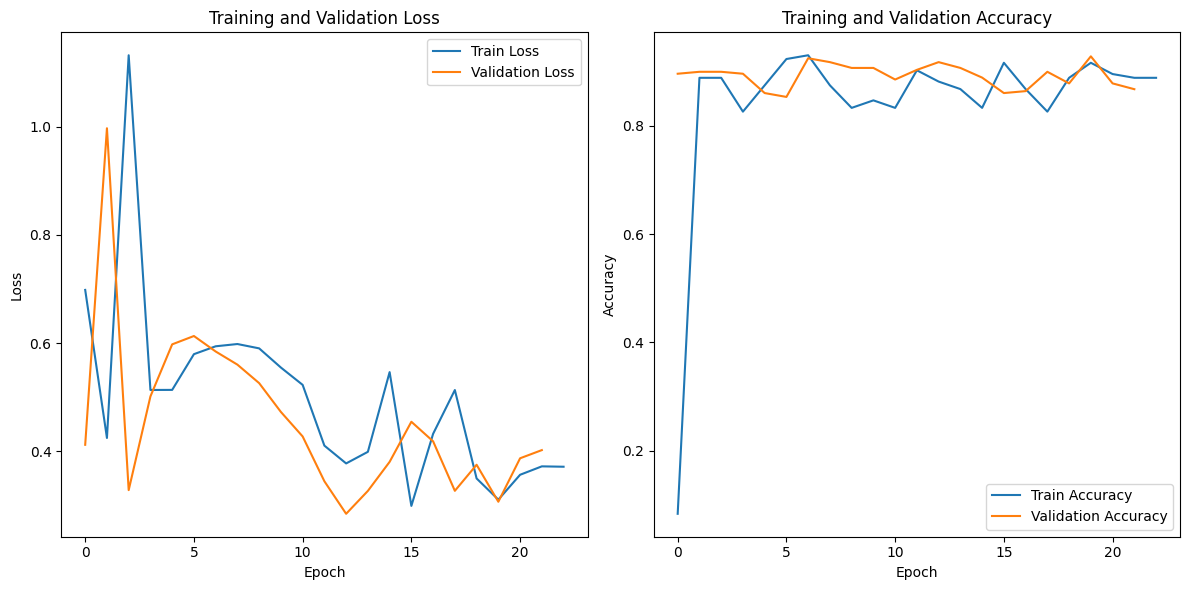

In [15]:
import matplotlib.pyplot as plt

# loss, accuracy visualization
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()